In [8]:
import torch

import triton
import triton.language as tl
import matplotlib
import pandas as pd
import numpy as np
print(torch.cuda.get_device_name(0))


NVIDIA RTX PRO 6000 Blackwell Workstation Edition


In [9]:
# We can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `_matmul`.
@triton.jit
def leaky_relu(x):
    x = x + 1
    return tl.where(x >= 0, x, 0.01 * x)

# `triton.jit`'ed functions can be auto-tuned by using the `triton.autotune` decorator, which consumes:
#   - A list of `triton.Config` objects that define different configurations of
#       meta-parameters (e.g., `BLOCK_SIZE_M`) and compilation options (e.g., `num_warps`) to try
#   - An auto-tuning *key* whose change in values will trigger evaluation of all the
#       provided configs
@triton.autotune(
    configs=[
        # triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
    ],
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel(
    # Pointers to matrices
    a_ptr, b_ptr, c_ptr,
    # Matrix dimensions
    M, N, K,
    # The stride variables represent how much to increase the ptr by when moving by 1
    # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
    # by to get the element one row down (A has M rows).
    stride_am, stride_ak,
    stride_bk, stride_bn,
    stride_cm, stride_cn,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr,
    ACTIVATION: tl.constexpr,
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetics` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] + k * BLOCK_SIZE_K < K , other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] + k * BLOCK_SIZE_K < K, other=0.0)
        # We accumulate along the K dimension.
        accumulator += tl.dot(a, b, out_dtype=tl.float32)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    if ACTIVATION == "leaky_relu":
        accumulator = leaky_relu(accumulator)
    c = accumulator.to(tl.bfloat16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


In [10]:
def matmul(a, b, activation=""):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    assert b.is_contiguous(), "Matrix B must be contiguous"
    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=a.dtype)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (
        triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']),
    )
    matmul_kernel[grid](
        a, b, c,
        M, N, K,
        a.stride(0), a.stride(1),
        b.stride(0), b.stride(1),
        c.stride(0), c.stride(1),
        ACTIVATION=activation
    )
    return c


In [11]:
def unit_test():
    torch.manual_seed(0)
    M, K, N = 512, 1024, 768
    a = torch.randn((M, K), device='cuda', dtype=torch.float16).contiguous() / np.sqrt(M) # (M, K)
    b = torch.randn((K, N), device='cuda', dtype=torch.float16).contiguous() / np.sqrt(N) # (K, N)
    triton_output = matmul(a, b)
    torch_output = torch.matmul(a, b)
    print(f"triton_output={triton_output}")
    print(f"torch_output={torch_output}")
    if torch.allclose(triton_output, torch_output, atol=1e-5, rtol=1e-2):
        print("✅ Triton and Torch match")
    else:
        print("❌ Triton and Torch differ")

unit_test()


triton_output=tensor([[-0.0183, -0.0079, -0.0698,  ..., -0.0396, -0.0114,  0.0806],
        [-0.0554,  0.0156, -0.1147,  ..., -0.0188, -0.0776, -0.0752],
        [ 0.0659,  0.0928,  0.0110,  ..., -0.0057,  0.0659,  0.0991],
        ...,
        [-0.0542, -0.0130,  0.0566,  ...,  0.1045, -0.0640, -0.0018],
        [ 0.0067, -0.0520,  0.0233,  ..., -0.0286, -0.0447, -0.0120],
        [-0.0183, -0.0635,  0.0009,  ..., -0.0339, -0.0167, -0.0033]],
       device='cuda:0', dtype=torch.float16)
torch_output=tensor([[-0.0183, -0.0079, -0.0697,  ..., -0.0395, -0.0114,  0.0807],
        [-0.0553,  0.0155, -0.1147,  ..., -0.0188, -0.0778, -0.0750],
        [ 0.0658,  0.0930,  0.0110,  ..., -0.0057,  0.0657,  0.0993],
        ...,
        [-0.0541, -0.0130,  0.0567,  ...,  0.1045, -0.0638, -0.0018],
        [ 0.0067, -0.0521,  0.0234,  ..., -0.0285, -0.0446, -0.0119],
        [-0.0183, -0.0637,  0.0009,  ..., -0.0338, -0.0168, -0.0033]],
       device='cuda:0', dtype=torch.float16)
✅ Triton and To

In [12]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['M', 'N', 'K'],  # Argument names to use as an x-axis for the plot
        x_vals=[
            128 * i for i in range(2, 42)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['cublas', 'triton'],
        # Label name for the lines
        line_names=["cuBLAS", "Triton"],
        # Line styles
        styles=[('green', '-'), ('blue', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
)
def benchmark(M, N, K, provider):
    a = torch.randn((M, K), device='cuda', dtype=torch.float16)
    b = torch.randn((K, N), device='cuda', dtype=torch.float16)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'cublas':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, b), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


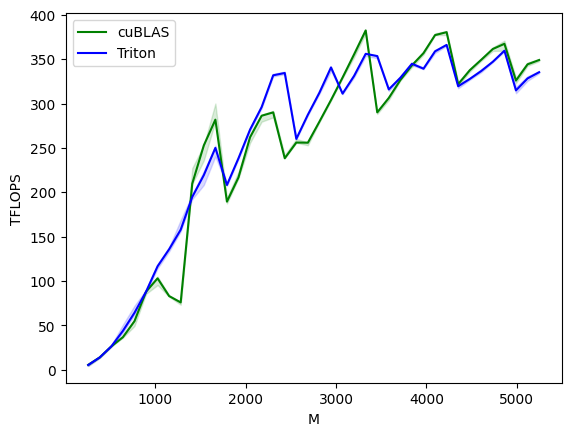

matmul-performance:
         M       N       K      cuBLAS      Triton
0    256.0   256.0   256.0    5.433036    5.216796
1    384.0   384.0   384.0   13.824000   13.824000
2    512.0   512.0   512.0   26.214401   26.214401
3    640.0   640.0   640.0   36.571428   43.690666
4    768.0   768.0   768.0   54.655507   64.053287
5    896.0   896.0   896.0   87.808000   87.808000
6   1024.0  1024.0  1024.0  102.927703  116.508440
7   1152.0  1152.0  1152.0   82.943997  135.726544
8   1280.0  1280.0  1280.0   75.807981  157.728042
9   1408.0  1408.0  1408.0  209.683695  194.706283
10  1536.0  1536.0  1536.0  252.781711  219.256948
11  1664.0  1664.0  1664.0  281.766330  249.969769
12  1792.0  1792.0  1792.0  189.395241  208.137481
13  1920.0  1920.0  1920.0  216.740820  238.344822
14  2048.0  2048.0  2048.0  262.016062  270.600262
15  2176.0  2176.0  2176.0  286.203006  295.935995
16  2304.0  2304.0  2304.0  289.989336  331.775988
17  2432.0  2432.0  2432.0  238.277982  334.395705
18  2560.0 

In [13]:
benchmark.run(show_plots=True, print_data=True)
